# Quest Killarney March 2017 Results Analyser
## by Barry Fitzgerald


In [1]:
# Setup imports and settings
import pandas as pd
import numpy as np
from IPython.display import Markdown
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
pd.set_option('display.max_rows', 1000)

In [8]:
# Get raw results data
raw_results = pd.read_html('http://www.redtagtiming.com/results/QKM2017_55km.html', attrs={'id': 'results'})[0]

In [9]:
raw_results

,Place,Number,Name,Surname,Cat,Sex,Wave,End Cycle,Run Turn,End Run,Finish,Race Time
0,1,2009,Mark,Nolan,Senior,M,Wave 4,0:41:03,0:32:03,0:30:54,0:39:56,2:23:56
1,2,2310,Michael,Buckley,Over40,M,Wave 4,0:44:13,0:31:44,0:30:42,0:40:41,2:27:20
2,3,2304,Mark,Wolfe,Over40,M,Wave 4,0:44:20,0:32:19,0:30:28,0:42:57,2:30:04
3,4,2122,Dessie,Duffy,Senior,M,Wave 4,0:46:23,0:32:09,0:30:03,0:42:20,2:30:55
4,5,2088,Matt,Casey,Over40,M,Wave 4,0:42:00,0:36:40,0:33:14,0:40:01,2:31:55
5,6,2267,Kevin,Murphy,Over50,M,Wave 4,0:42:39,0:36:14,0:33:02,0:40:05,2:32:00
6,7,2168,Gary,Lawlor,Senior,M,Wave 4,0:43:54,0:35:07,0:33:22,0:43:00,2:35:23
7,8,2021,Roland,Eagar,Over40,M,Wave 4,0:43:52,0:36:58,0:33:01,0:44:45,2:38:36
8,9,2293,Harry,Clifton,Over40,M,Wave 4,0:46:47,0:36:45,0:32:10,0:45:06,2:40:48
9,10,2030,David,Sheehan,Over40,M,Wave 4,0:45:25,0:36:24,0:33:48,0:46:07,2:41:44


In [10]:
# Clean data and convert all durations to hours
from datetime import datetime as dt
results = raw_results[:-1]
results = results.rename(columns=lambda c: c.replace(' ', '_').replace('.', '_').lower())
results = results.assign(end_cycle=lambda x: pd.to_timedelta(x.end_cycle) / np.timedelta64(1, 'h'),
               run_turn=lambda x: pd.to_timedelta(x.run_turn) / np.timedelta64(1, 'h'),
               end_run=lambda x: pd.to_timedelta(x.end_run) / np.timedelta64(1, 'h'),
               finish=lambda x: pd.to_timedelta(x.finish) / np.timedelta64(1, 'h'),
               race_time=lambda x: pd.to_timedelta(x.race_time, errors='coerce') / np.timedelta64(1, 'h'),
               number=lambda x: x.number.astype(int)
              )
results['total_run'] = results.run_turn + results.end_run
results['total_cycle'] = results.end_cycle + results.finish

## Race Number:

In [11]:
race_number = 2140

In [13]:
# Get Athlete's results
my_results = results.ix[results.number == race_number].iloc[0]
md = []
md.append("## Athlete: " + my_results['name'] + ' ' + my_results.surname)
md.append('### Position: ' + str(my_results['place']))
md.append('### Total Time: ' + str(my_results['race_time'].round(2)) + ' (hours)')

Markdown('\n'.join(md))

## Athlete: Barry Fitzgerald
### Position: 130
### Total Time: 3.6 (hours)

---
# Finish Time Distributions

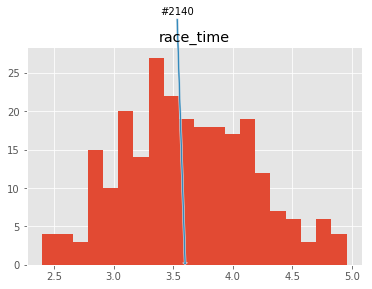

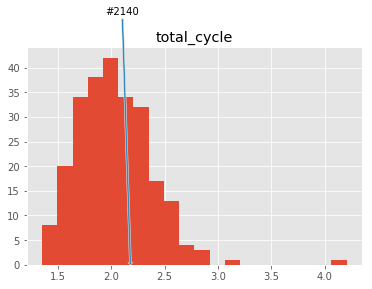

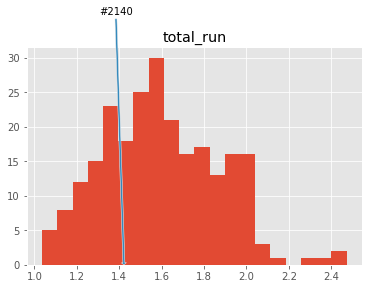

In [15]:
for t in ['race_time', 'total_cycle', 'total_run']:
    plt.figure()
    results[[t]].hist(bins=20, label='55km Total Time (hours)')
    plt.annotate('#' + str(race_number), xy=(my_results[t],0), xytext=(-25, 250),
                 arrowprops={'width': 2, 'headlength': 2,
                             'headwidth': 5},
                 textcoords='offset pixels')

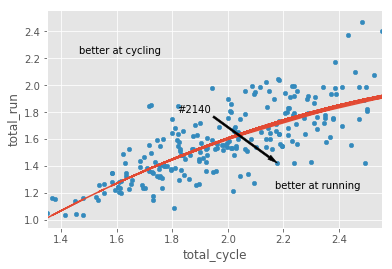

In [16]:
#X,Y scatter of run vs cycle times
filter_results = results[['total_cycle', 'total_run']].dropna()
ax = filter_results.plot.scatter(x='total_cycle', y='total_run')
plt.annotate('#' + str(race_number), xy=(my_results['total_cycle'], my_results['total_run']), xytext=(-100, 50),
                 arrowprops={'width': 2, 'headlength': 10,
                             'headwidth': 5, 'color': 'black'},
                 textcoords='offset pixels')


plt.annotate('better at cycling', xy=(0.2,0.8), xycoords='figure fraction')
plt.annotate('better at running', xy=(0.7,0.3), xycoords='figure fraction')


# get rid of some outliers for the trendline fit
filter_results['ratio'] = filter_results['total_cycle'] / filter_results['total_run']
upper_bound = filter_results['ratio'].quantile(0.95)
lower_bound = filter_results['ratio'].quantile(0.05)
fit_results = filter_results.ix[(filter_results['ratio'] < upper_bound) & (filter_results['ratio'] > lower_bound)]

# Relationship looks slightly curved - running is harder the less fit you are...
z = np.polyfit(x=fit_results['total_cycle'].values, y=fit_results['total_run'].values, deg=2)
p = np.poly1d(z)

trendline = pd.DataFrame(data=p(filter_results['total_cycle'].values), index=filter_results['total_cycle'].values)
trendline.name= 'trend' 
trendline.plot(ax=ax, legend=False)